In [1]:
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd

In [2]:
import os
import pandas as pd

# Pfad zum Verzeichnis, das die Attitude Roots enthält
root_dir = r'../../../data/attitude_roots/' 

# Liste für die Ergebnisse
data = []

# Durchlaufe alle Unterverzeichnisse im Root-Verzeichnis
for attitude_root in os.listdir(root_dir):
    attitude_path = os.path.join(root_dir, attitude_root)
    # Prüfe, ob es sich um ein Verzeichnis handelt
    if os.path.isdir(attitude_path):
        review_path = os.path.join(attitude_path, 'review')
        # Prüfe, ob der 'review'-Ordner existiert
        if os.path.exists(review_path):
            # Durchlaufe alle Dateien im 'review'-Ordner
            for filename in os.listdir(review_path):
                file_path = os.path.join(review_path, filename)
                # Nur Dateien berücksichtigen
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        # Sätze durch Zeilenumbrüche getrennt
                        sentences = content.strip().split('\n')
                        for sentence in sentences:
                            # Überspringe leere Zeilen
                            if sentence.strip():
                                data.append({
                                    'data': sentence.strip(),
                                    'labels': attitude_root
                                })

df = pd.DataFrame(data)

print(df)


                                                   data         labels
0     With regard to my first negative point above a...      arg_other
1     The cited paper 'Learning an adaptive learning...      arg_other
2         The above papers are not cited in this paper.      arg_other
3     Missing references - authors may want to consi...      arg_other
4     Some of the experiments (eg. comparisons invol...      arg_other
...                                                 ...            ...
1806  - From Figure 9, we see the certificate radii ...  asp_substance
1807  1. (Also AREA CHAIR NOTE): Another parallel su...  asp_substance
1808  2. Even though Figure 2b shows that SVHN test ...  asp_substance
1809  I don’t see a significant difference between R...  asp_substance
1810  It is not clear how the compression ratio in t...  asp_substance

[1811 rows x 2 columns]


In [3]:

df["labels"].unique()




array(['arg_other', 'asp_clarity', 'asp_meaningful-comparison',
       'asp_motivation-impact', 'asp_originality', 'asp_replicability',
       'asp_substance'], dtype=object)

In [4]:
#Encode label for easy identification.
df["encoded_cat"] = df["labels"].astype("category").cat.codes
#print(df)


# Häufigkeit der Labels zählen
label_counts = df['labels'].value_counts()

print("Verteilung der Labels:")
print(label_counts)


Verteilung der Labels:
labels
asp_substance                739
asp_clarity                  440
asp_replicability            191
asp_originality              171
asp_meaningful-comparison    154
asp_motivation-impact         69
arg_other                     47
Name: count, dtype: int64


In [8]:
data_texts = df["data"].to_list() # Features (not tokenized yet)
data_labels = df["encoded_cat"].to_list() # Labels

In [9]:
# Data Split (train 79%, val 20%, test 1%)

from sklearn.model_selection import train_test_split
 
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [7]:
print(len(train_texts)/1811)
print(len(val_texts))
print(len(test_texts)/1811)

print(train_texts)

0.7912755383765875
363
0.008282716731087797
['- Baseline missing: Random actions from expert', 'This is not so interesting, even though results are impressive.', '- Lack of a strong explanation for the results or a solution to the problem', 'Although a detailed discussion is provided related to the memory consumption between the proposed method and PipeDream, no detailed discussion is provided with respect to GPipe.', '- Please comment on the extra computation required for obtaining image data for MT sentences and for learning image representations.', 'This needs to be changed: a) you should run all the baselines for each of the current tasks b) you should also expand the experiments evaluated to include tasks where it is not obvious that a hierarchy would help/is necessary c) you should include more baselines.', 'Why, for example, did the authors only perform variational inference with the current and previous frames? Did conditioning on additional frames offer limited further improve

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [11]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
dict(train_encodings),
train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
dict(val_encodings),
val_labels
))

In [14]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=7)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
 
model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=2,
    batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks=[early_stopping]
)

Epoch 1/2


49/90 [===============>..............] - ETA: 3:17 - loss: 1.6151 - accuracy: 0.4260

In [16]:
predict_input = tokenizer.encode(val_texts[2],
    truncation=True,
    padding=True,
    return_tensors="tf")
 
output = model(predict_input)[0]
print(output)
 
prediction_value = tf.argmax(output, axis=1).numpy()[0]
 
# Convert numeric prediction to category label
if prediction_value == 0:
    prediction_label = "Other"
elif prediction_value == 1:
    prediction_label = "Clarity"
elif prediction_value == 2:
    prediction_label = "Comparison"
elif prediction_value == 3:
    prediction_label = "Motivation"
elif prediction_value == 4:
    prediction_label = "Orginality"
elif prediction_value == 5:
    prediction_label = "Replicability"
else:
    prediction_label = "Substance" 
 
print("🤖Predicted Category:", prediction_label)
print(val_labels[2])

tf.Tensor(
[[ 0.04943598 -0.03148741  0.01636142  0.07095795  0.02438408  0.07774305
   0.05042113]], shape=(1, 7), dtype=float32)
🤖Predicted Category: Replicability
6


In [17]:
def predict_category(text):
    predict_input = tokenizer.encode(text,
    truncation=True,
    padding=True,
    return_tensors="tf")
    output = model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

In [ ]:
print(test_labels)

[1, 6, 0, 6, 6, 4, 4, 5, 6, 6, 2, 6, 5, 1, 5]


5 true:  5
5 true:  6
5 true:  6
5 true:  2
5 true:  6
5 true:  6
5 true:  6
0 true:  6
6 true:  2
5 true:  4
5 true:  5
5 true:  5
5 true:  6
5 true:  5
5 true:  1
5 true:  0
3 true:  6
5 true:  5
5 true:  1
5 true:  6
3 true:  1
5 true:  6
5 true:  2
3 true:  5
3 true:  6
5 true:  6
0 true:  6
5 true:  5
5 true:  6
5 true:  6
5 true:  2
5 true:  6
5 true:  1
5 true:  6
5 true:  5
3 true:  1
5 true:  6
5 true:  0
5 true:  4
5 true:  5
5 true:  5
5 true:  1
5 true:  6
0 true:  6
5 true:  1
5 true:  1
5 true:  1
5 true:  6
5 true:  5
5 true:  2
5 true:  6
3 true:  6
5 true:  6
3 true:  6
3 true:  6
5 true:  6
5 true:  6
5 true:  6
6 true:  1
5 true:  2
5 true:  0
5 true:  4
5 true:  3
3 true:  6
5 true:  5
3 true:  2
5 true:  2
5 true:  3
3 true:  6
5 true:  6
3 true:  4
5 true:  6
4 true:  1
0 true:  5
3 true:  1
3 true:  6
5 true:  6
3 true:  1
4 true:  1
5 true:  6
3 true:  1
5 true:  1
3 true:  3
3 true:  1
5 true:  6
5 true:  2
5 true:  1
0 true:  1
6 true:  3
5 true:  0
5 true:  6

<Axes: >

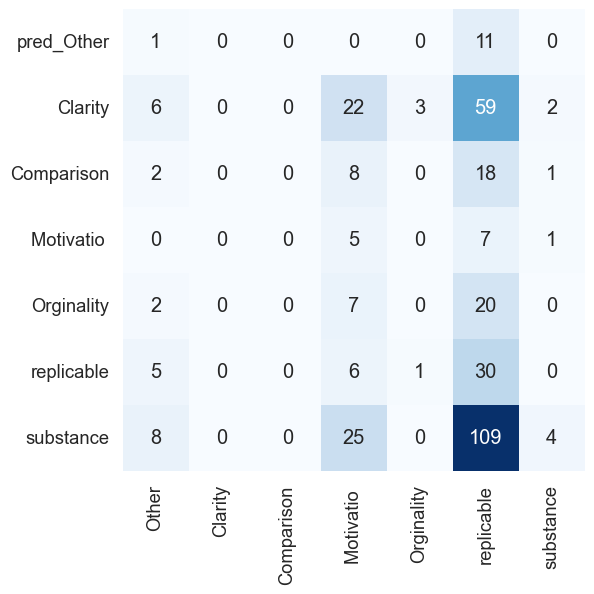

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = []
for v, y in zip(val_texts, val_labels):
    print(predict_category(v), "true: ", y)
    y_pred.append(predict_category(v))


confusion = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
xticklabels=["Other", "Clarity", "Comparison", "Motivatio ", "Orginality", "replicable", "substance"], yticklabels=["pred_Other", "Clarity", "Comparison", "Motivatio ", "Orginality", "replicable", "substance"])

In [ ]:
from tensorflow.keras.models import load_model
save_directory = "Multitext_Classification_colab" 

model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

In [ ]:
# Evaluate

save_directory = "Multitext_Classification_2"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

